In [58]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from empmap.collate_map import EmpiricalMap
from empmap.poly_fit import mu_fit_selector
from empmap.potential import Potential1D
from empmap.sincdvr import DVR
from empmap.constants import ConstantsManagement

constants = ConstantsManagement()

### Set the Plot Settings

In [59]:
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.titlesize']=16
rcParams['font.size']=12
rcParams['axes.titlesize']=16
rcParams['axes.labelsize']=24
rcParams['figure.labelsize']=28
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
rcParams['axes.linewidth'] = 1.5
rcParams['lines.markersize']=4
rcParams['lines.linewidth']=2.5
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams['xtick.bottom'] = True
rcParams['xtick.top']=True
rcParams['xtick.direction']="in"
rcParams['ytick.left'] = True
rcParams['ytick.right'] = True
rcParams['ytick.direction']="in"
rcParams['svg.fonttype'] = 'none'

## Load the Map and Refit It

The empirical map that has already been created can be loaded back into the class as a pickle file through the load_self function. This takes exactly one argument which is the pickle file. 

Right now, the data here being loaded (doh_do_gas.pckl) is for the OH stretch in DOH/D2O for the SPCE water model. It should be relatively similar to the data presented in:

Auer & Skinner. J. Chem. Phys. 2008, 128 (22), 224511.

In [60]:
new_map = EmpiricalMap.load_self("example_maps/doh_d2o_gas.pckl")

To fit the parameters of the map, one can use the fit_full_empirical map function. Here sigma_pos=[-1] identifies that the gas phase data is the final position in the array.

In [61]:
new_map.fit_full_empirical_map(order_omega=2, order_x=1, order_mu=1, sigma_pos=[-1])
print("******* Fit R^2 Values ********")
for key in new_map.map_fit_parameters.keys():
    print(f"{key:} {new_map.map_fit_parameters[key][2]:10.5f}")

experimental_w01 = 3707 ## Experimental value for w01 in cm^-1

print(new_map.w01[-1], new_map.w01[0]/experimental_w01) # Scaling factor
scale_factor = new_map.w01[-1]/experimental_w01


w01 = 3720.1847933917 + -3622.5526895387*Eproj + -83153.2049434688*Eproj^2
w12 = 3563.2717522744 + -4141.9649369350*Eproj + -104090.0431870354*Eproj^2
x01 = 0.1026298437 + -0.0000092577*w01
x12 = 0.1428428220 + -0.0000127902*w12
dmu_num = 0.2395298256 + 22.4636816454*Eproj
dmu = 0.2445919375 + 23.4821610348*Eproj
dmu_num_scaled = 1.1815457162 + 89.4891788369*E
dmu_scaled = 1.0517831194 + 100.9769206382*E
******* Fit R^2 Values ********
w01    0.76646
w12    0.77358
x01    0.99851
x12    0.99810
dmu_num    0.82497
dmu    0.83478
dmu_num_scaled    0.82734
dmu_scaled    0.83478
3713.5190185518395 0.9282857690370445


### First Vibrational Transition

This corresponds to the w01 transition.

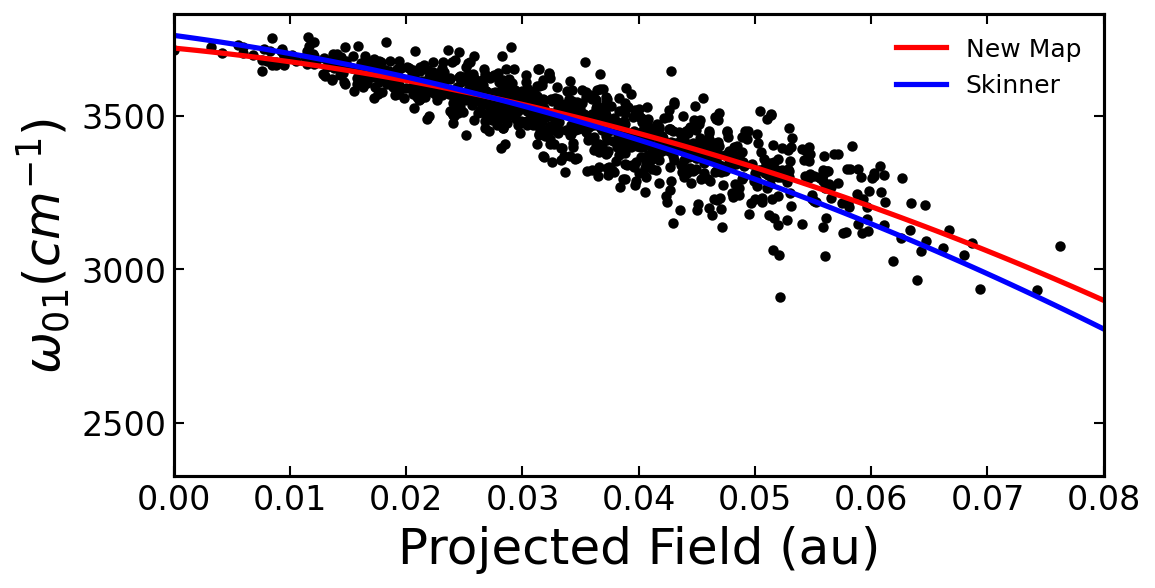

In [62]:
popt, pcov, r2 = new_map.map_fit_parameters['w01']
poly = mu_fit_selector(2)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)
skinner = poly(evals, 3761.6, -5060.4, -86225)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.Eproj, new_map.w01, c='black')
plt.plot(evals, yvalues, c='red', label='New Map')
plt.plot(evals, skinner, c='blue', label='Skinner')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\omega_{01} (cm^{-1})$")
plt.legend(frameon=False)
plt.xlim(0, 0.08)
plt.show()

## The Second Vibrational Transition

This is the w12 transition.

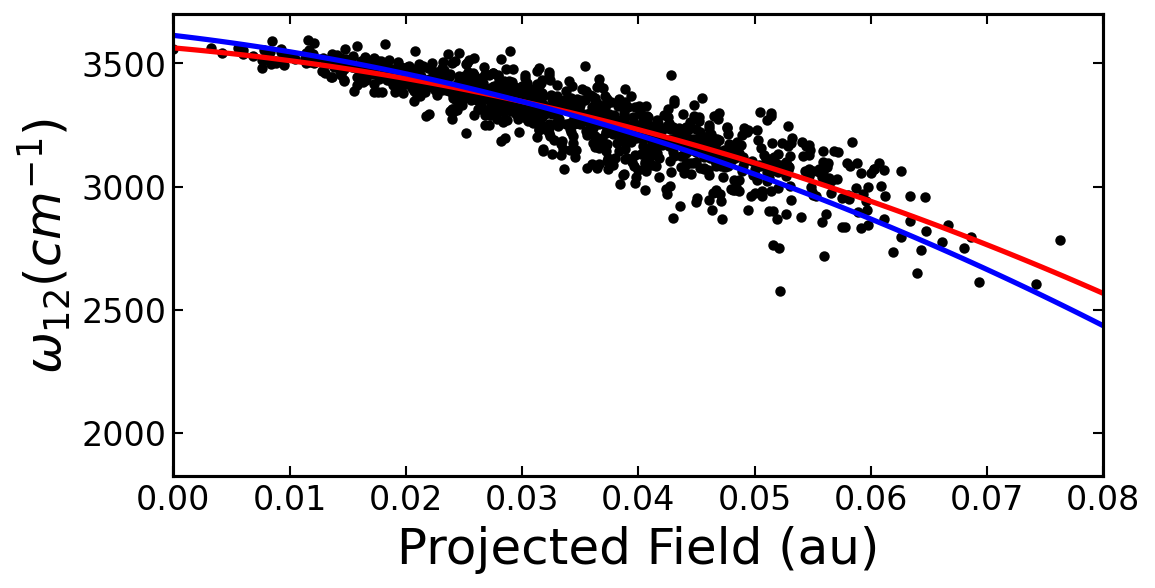

In [63]:
popt, pcov, r2 = new_map.map_fit_parameters['w12']
poly = mu_fit_selector(2)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)
skinner = poly(evals, 3614.1, -5493.7, -115670)

fig = plt.figure(figsize=(8,4), dpi=150)
plt.scatter(new_map.Eproj, new_map.w12, c='black')
plt.plot(evals, yvalues, c='red')
plt.plot(evals, skinner, c='blue')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\omega_{12} (cm^{-1})$")
plt.xlim(0, 0.08)
plt.show()

## The Anharmonicity

This is w01 - w12.

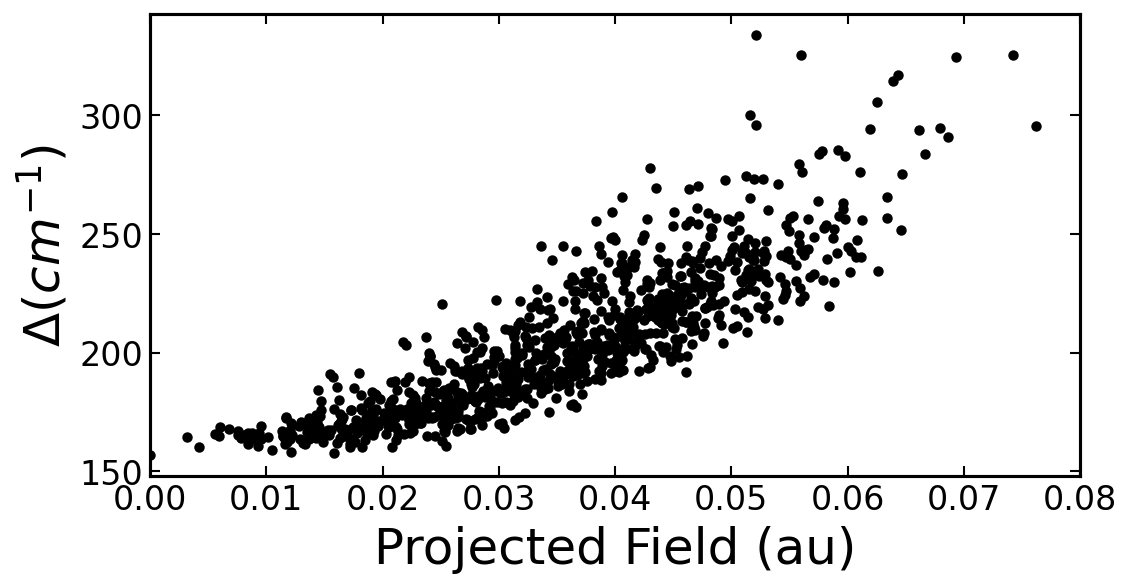

In [64]:
fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.Eproj, np.array(new_map.w01)-np.array(new_map.w12), c='black')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\Delta (cm^{-1})$")
plt.xlim(0, 0.08)
plt.show()

## The Dipole Moment Derivative

This is the derivative of the dipole moment. This is calculated a few ways in the code, but this is the only one that actually worked the way I intended.

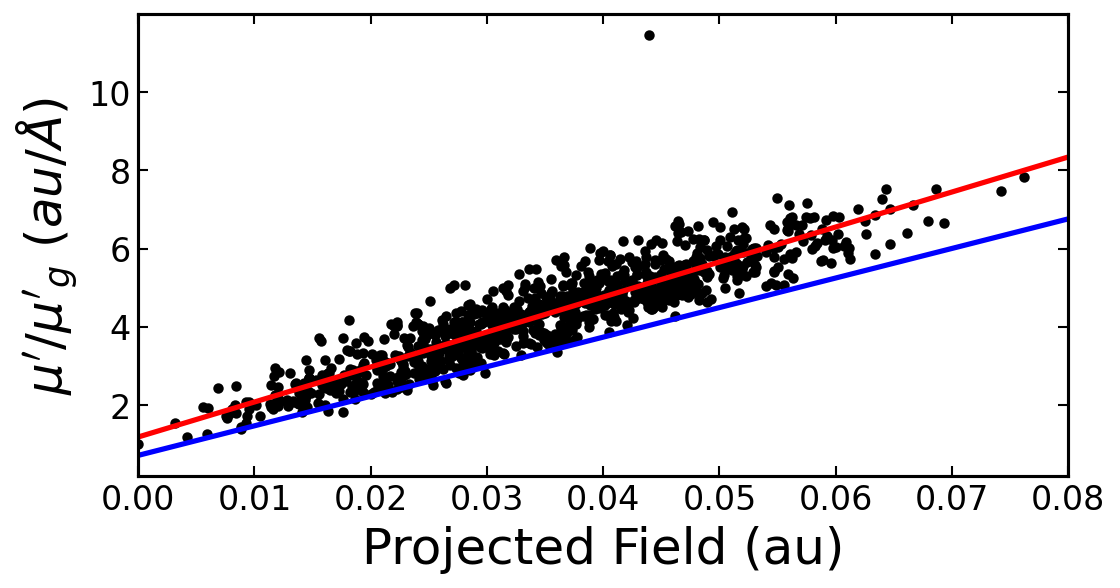

In [65]:
popt, pcov, r2 = new_map.map_fit_parameters['dmu_num_scaled']
poly = mu_fit_selector(1)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)

skinner = poly(evals, 0.71116, 75.591)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.Eproj, new_map.dmu_num/new_map.dmu_num[-1], c='black')
plt.plot(evals, skinner, c='blue')
plt.plot(evals, yvalues, c='red')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\mu'/\mu'_g~(au/\AA)$")
plt.xlim(0, 0.08)
plt.show()

## Position Matrix Element

This is x01.

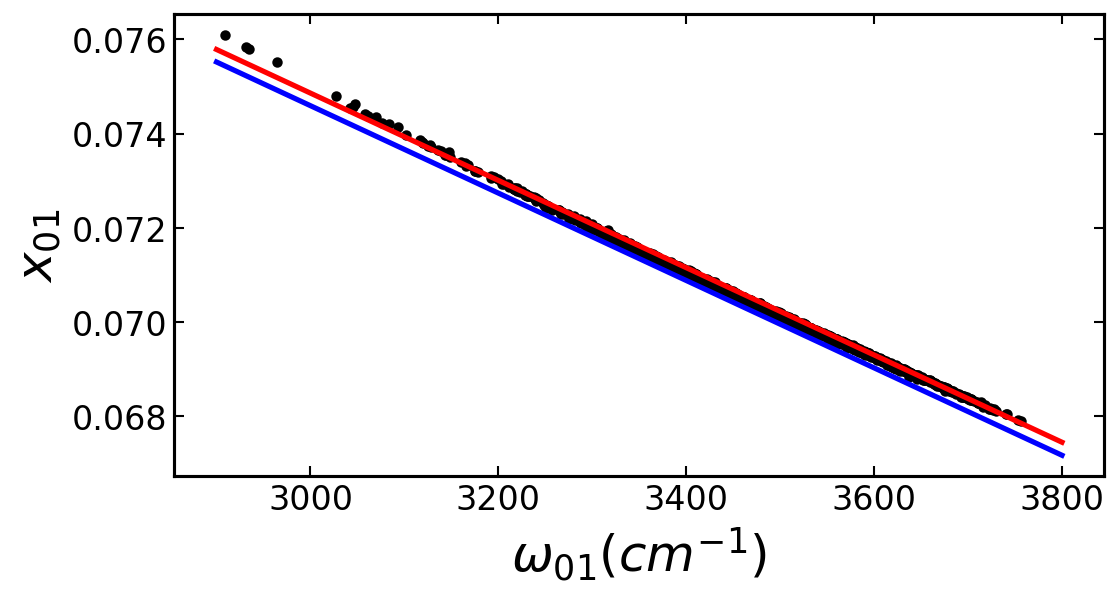

In [66]:
popt, pcov, r2 = new_map.map_fit_parameters['x01']
poly = mu_fit_selector(1)

evals = np.linspace(2900, 3800, 1000)
yvalues = poly(evals, *popt)
skinner = poly(evals, 0.1024, -0.927E-5)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.w01, np.array(new_map.x01)*constants.angperau, c='black')
plt.plot(evals, yvalues, c='red')
plt.plot(evals, skinner, c='blue')
plt.xlabel("$\omega_{01} (cm^{-1})$")
plt.ylabel("$x_{01}$")
plt.show()

## Build a Potential for a Gas Phase Molecule

This code is an example of how to dispaly the eigenvalues and eigenfunctions for the 1D potentials used to build the empirical map.

In this first section, the Potential is built from the gaussian calcualtions, and then the potential is fit by fitting functions of order 8 and 3, respectively.

In [67]:
pot1d = Potential1D("example_potential/scan_rOHs.dat", 
                    "example_potential/scan_energies.dat", 
                    "example_potential/scan_dipoles.dat", 
                    "example_potential/scan_eOHs.dat")
pot1d.fit_potential_to_poly(8)
pot1d.fit_dipole_to_poly(4)

dvr = DVR(pot1d, emax=10.0, xmax=2.1, mass1=2.0014, mass2=15.999)
dvr.do_calculation()

This is the code to plot the eigenvalues on the potential energy surface.

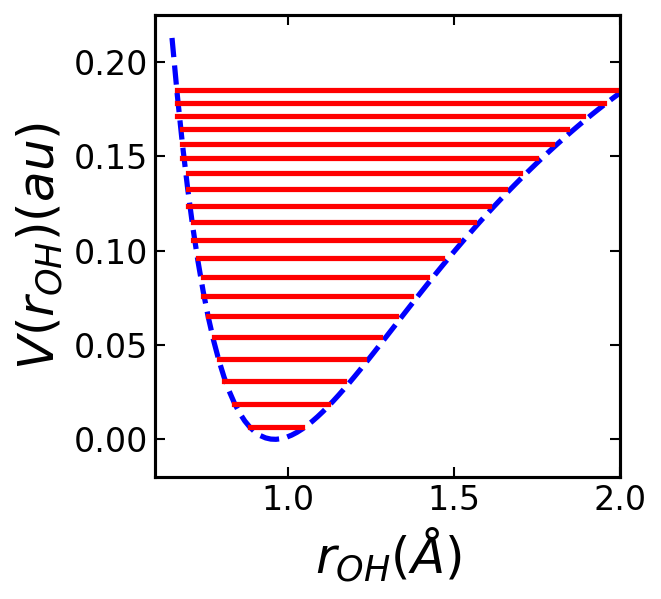

In [68]:
fig = plt.figure(figsize=(4,4),dpi=150)
display=True
xvals = np.linspace(0.65, 2.2, 100)


plt.plot(xvals, dvr.pot1d.pot_fit['poly'](xvals, *dvr.pot1d.pot_fit['popt']), c='blue', ls = '--')
#plt.scatter(dvr.pot1d.rOH, dvr.pot1d.pot_energy, c='black', s=20)
#plt.scatter(dvr.xgrid*constants.angperau, dvr.pot1d.pot_fit['poly'](dvr.xgrid*constants.angperau, *dvr.pot1d.pot_fit['popt']), c='red')
if display:
    for eval in dvr.evals[:20]:
        # find the two intersectiosn between dvr.pot1d.pot_fit['poly'](xvals, *dvr.pot1d.pot_fit['popt']) and the eval
        lower = np.argmin(np.abs(dvr.pot1d.pot_fit['poly'](xvals[xvals<1.0], *dvr.pot1d.pot_fit['popt']) - eval))
        upper = np.argmin(np.abs(dvr.pot1d.pot_fit['poly'](xvals[xvals>1.0], *dvr.pot1d.pot_fit['popt']) - eval)) + len(xvals[xvals<1.0])
        plt.plot(xvals[lower:upper], [eval] * len(xvals[lower:upper]), c='red')
plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$V(r_{OH}) (au)$")
plt.xlim(0.6,2)
plt.ylim(-0.02,0.225)
plt.show()


This is the code for printing the first three probability densities.

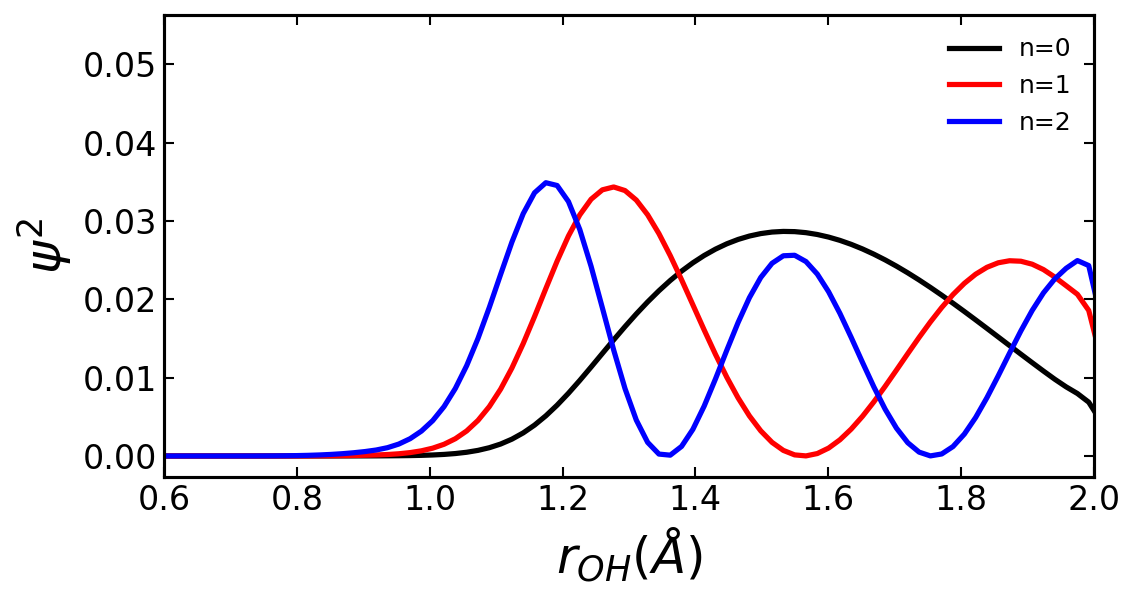

In [69]:
fig = plt.figure(figsize=(8,4),dpi=150)
plt.plot(dvr.xgrid*constants.angperau, np.multiply(dvr.evecs[0], dvr.evecs[0]), c='black', label='n=0')
plt.plot(dvr.xgrid*constants.angperau, np.multiply(dvr.evecs[1], dvr.evecs[1]), c='red', label='n=1')
plt.plot(dvr.xgrid*constants.angperau, np.multiply(dvr.evecs[2], dvr.evecs[2]), c='blue', label='n=2')
plt.xlim(0.6,2)
plt.legend(frameon=False)
plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$\psi^2$")
plt.show()

### The Dipole Moment Fitting

This code was used to diagnose the issues with the calculations of the dipole derivative.

First we calculate the raw potential energy surface on the grid, as a function of angstroms on the grid.

In [70]:
vraw = pot1d.pot_fit['poly'](
            dvr.xraw*constants.angperau, *dvr.pot1d.pot_fit['popt'])

Then we identify what the location of the equilibrium bond length on the grid is.

In [71]:
r0_index = np.argmin(vraw)
r0 = dvr.xraw[r0_index]

#Check that stored value is close to calculated value
assert abs(r0*constants.angperau - pot1d.pot_fit['r0']) < 0.01

Subtract the eq bond length from the grid, and find the index of the minimum

In [72]:
drOH = np.abs(dvr.xraw - r0)
imin = np.argmin(drOH)
print(f"imin is {imin}")

imin is 55


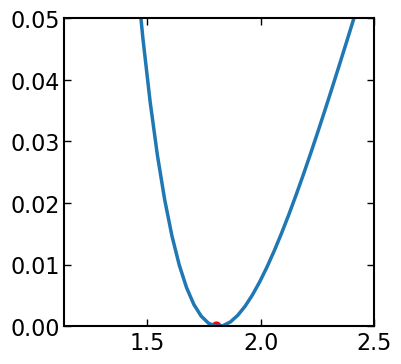

In [73]:
fig = plt.figure(figsize=(4,4))
plt.plot(dvr.xraw, vraw)
plt.scatter(r0, vraw[r0_index], c='red',s=40)
plt.ylim(0,0.05)
plt.xlim(0.6/constants.angperau, 2.5)
plt.show()

## Diagnosing the Derivative

Here is the plot of the dipole moment as a function of the bond distance

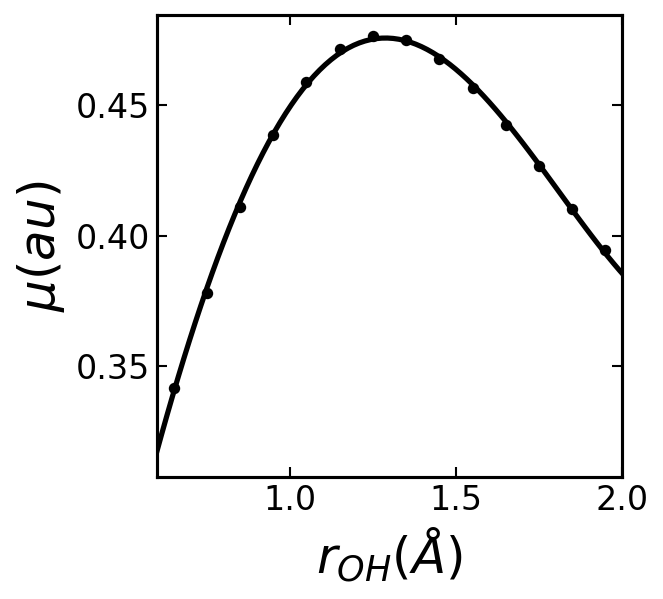

In [74]:
fig = plt.figure(figsize=(4,4),dpi=150)
mu_poly = pot1d.mu_fit['poly']
xdata = dvr.xgrid*constants.angperau
mu_data = mu_poly(xdata, *pot1d.mu_fit['popt'])
plt.plot(xdata, mu_data, c='black')
plt.scatter(pot1d.rOH, pot1d.mu, c='black', s=20)

plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$\mu (au)$")
plt.xlim(0.6,2)
plt.show()

In [75]:
def numerical_derivative(x, y):
    return np.gradient(y, x)

Here you can see that the dmu_data calcualted from dmu_popt are very very wrong. So there is something about how things are being set here that are not being handled appropriately. This is a problem, because this means that the closest we can do for the derivative is based on the spacing of the gaussian calculations

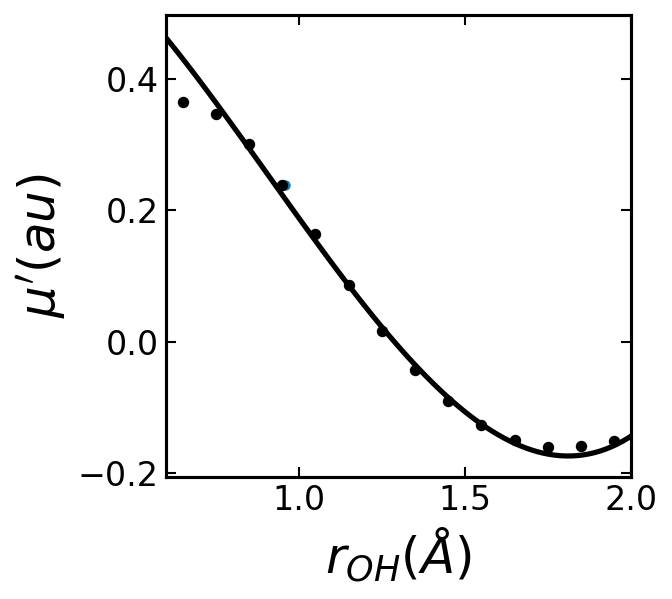

In [76]:
fig = plt.figure(figsize=(4,4),dpi=150)
dmu_poly = pot1d.mu_fit['mu_deriv_poly']
xdata = dvr.xgrid*constants.angperau
dmu_data = dmu_poly(xdata, *pot1d.mu_fit['dmu_popt'])
plt.plot(xdata, dmu_data, c='black')
plt.scatter(pot1d.pot_fit["r0"], pot1d.mu_fit['dmu_num'])
plt.scatter(pot1d.rOH, numerical_derivative(pot1d.rOH, pot1d.mu), c='black', s=20)
plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$\mu' (au)$")
plt.xlim(0.6,2)
plt.show()

In [101]:
alpha = np.genfromtxt("example_potential/scan_polarizability.dat")
alpha = alpha.T
iso = (alpha[0,:]+alpha[2,:] + alpha[5,:])/3
print(iso)
print(alpha[5,:])

[ 4.95189667  5.24979667  5.61214333  6.05057     6.57139667  7.17264
  7.84525     8.57669333  9.35442333 10.16796    11.00919    11.87171667
 12.75069667 13.64257    14.54487667 15.45644   ]
[ 4.86225  5.47181  6.25378  7.23266  8.42155  9.81549 11.3938  13.1267
 14.9835  16.9365  18.9628  21.0434  23.1636  25.312   27.4811  29.6668 ]


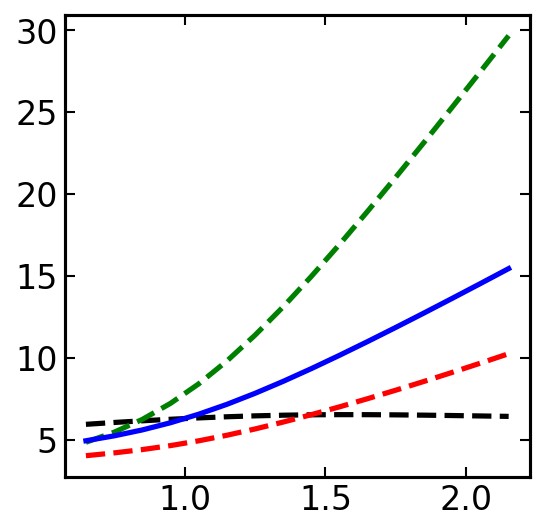

In [106]:
fig = plt.figure(figsize=(4,4),dpi=150)
plt.plot(pot1d.rOH, alpha[0,:], ls='--', c='black')
plt.plot(pot1d.rOH, alpha[2,:], ls='--', c='red')
plt.plot(pot1d.rOH, alpha[5,:], ls='--', c='green')
plt.plot(pot1d.rOH, iso, c='blue')

plt.show()

In [111]:
from empmap.poly_fit import mu_fit_selector
from scipy.optimize import curve_fit

poly = mu_fit_selector(6)
xdata = dvr.xgrid*constants.angperau
popt, pcov = curve_fit(poly, pot1d.rOH, iso)
ypol_vals = poly(xdata, *popt)

In [114]:
dalpha_popt = np.zeros(len(popt)-1)
for i in range(len(popt)-1):
    dalpha_popt[i] = (i+1)* popt[i+1]

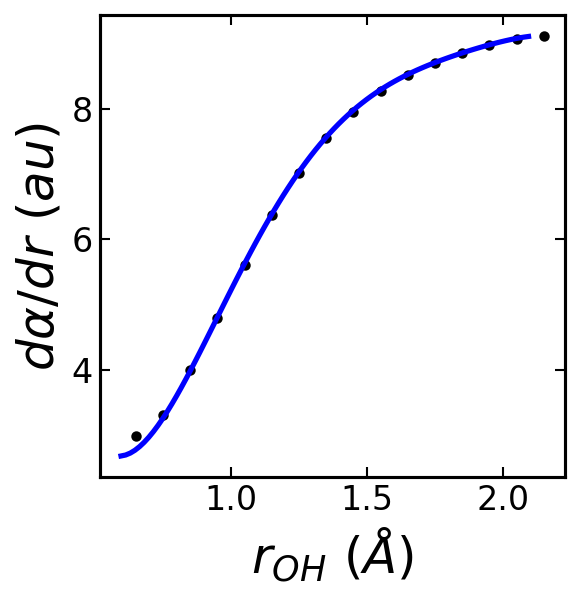

In [134]:
fig = plt.figure(figsize=(4,4),dpi=150)
numer_data = numerical_derivative(pot1d.rOH, iso)
yder_pol = mu_fit_selector(5)(xdata, *dalpha_popt)
plt.scatter(pot1d.rOH, numer_data, c='black')
plt.plot(xdata, yder_pol, c='blue')
plt.xlabel(r"$ r_{OH}~(\AA)$")
plt.ylabel(r'$d \alpha /dr~(au)$')
plt.show()

In [135]:
print(alpha[0])

[5.95411 6.06689 6.16952 6.26277 6.34548 6.41559 6.47102 6.51095 6.53519
 6.54521 6.54318 6.53166 6.51324 6.49026 6.46483 6.43862]


# TIP3P Map

In [77]:
tip_map = EmpiricalMap.load_self("example_maps/tip3p_map.pckl")

In [78]:
tip_map.fit_full_empirical_map(order_omega=2, order_x=1, order_mu=1, sigma_pos=[-1])
print("******* Fit R^2 Values ********")
for key in tip_map.map_fit_parameters.keys():
    print(f"{key:} {tip_map.map_fit_parameters[key][2]:10.5f}")

experimental_w01 = 3707 ## Experimental value for w01 in cm^-1

print(tip_map.w01[-1], tip_map.w01[0]/experimental_w01) # Scaling factor
scale_factor = tip_map.w01[-1]/experimental_w01


w01 = 3680.4751695028 + -2360.1589899026*Eproj + -105881.5644217726*Eproj^2
w12 = 3526.9116608734 + -2832.8930326671*Eproj + -127281.3583846527*Eproj^2
x01 = 0.1020993777 + -0.0000091519*w01
x12 = 0.1422254809 + -0.0000126601*w12
dmu_num = 0.2056643038 + 22.8881249318*Eproj
dmu = 0.2157773712 + 23.5589863697*Eproj
dmu_num_scaled = 1.1863651918 + 106.0886985803*E
dmu_scaled = 1.0933444774 + 119.3734417892*E
******* Fit R^2 Values ********
w01    0.76005
w12    0.77026
x01    0.99897
x12    0.99838
dmu_num    0.83426
dmu    0.84065
dmu_num_scaled    0.83685
dmu_scaled    0.84065
3693.647369377287 0.9694849908940907


### w01

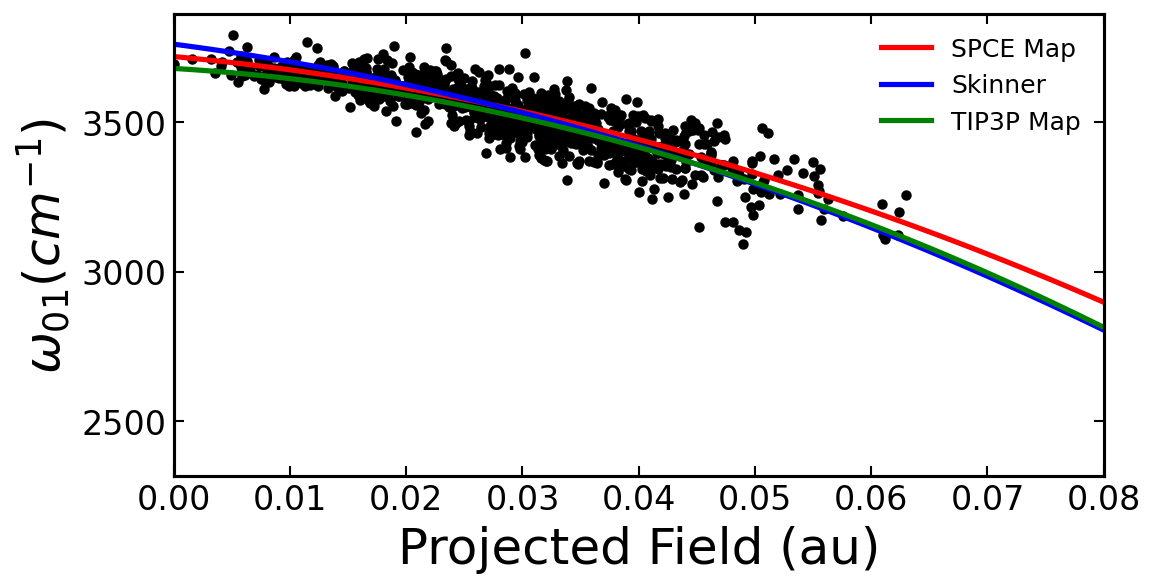

In [79]:
popt, pcov, r2 = tip_map.map_fit_parameters['w01']
poly = mu_fit_selector(2)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)
skinner = poly(evals, 3761.6, -5060.4, -86225)
spce = poly(evals, 3720.18, -3622.55, -83153.20)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(tip_map.Eproj, tip_map.w01, c='black')
plt.plot(evals, spce, c='red', label='SPCE Map')
plt.plot(evals, skinner, c='blue', label='Skinner')
plt.plot(evals, yvalues, c='green', label='TIP3P Map')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\omega_{01} (cm^{-1})$")
plt.legend(frameon=False)
plt.xlim(0, 0.08)
plt.show()

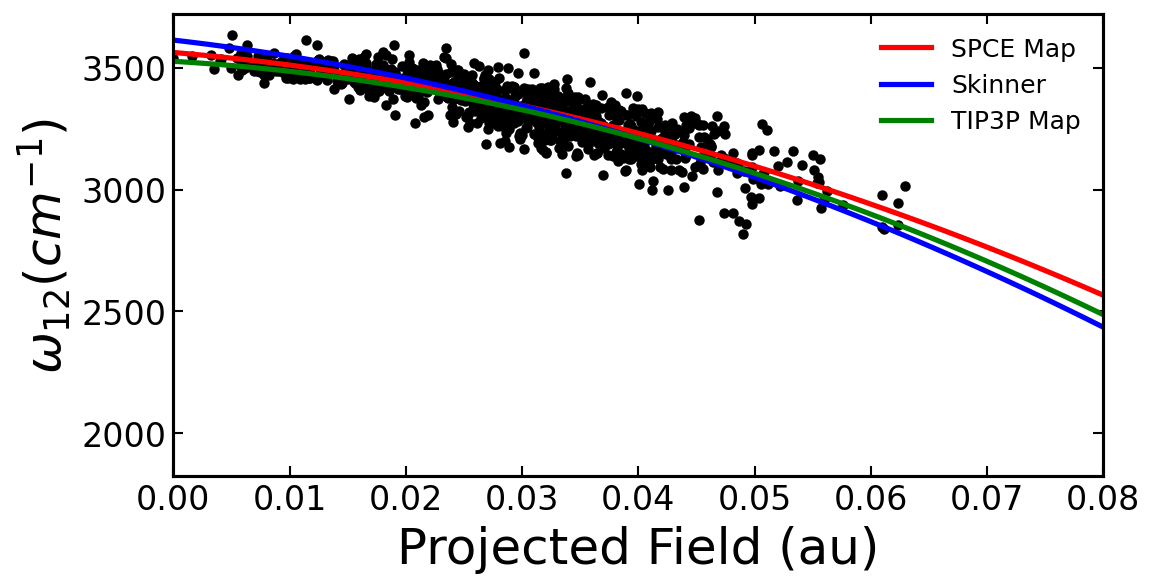

In [80]:
popt, pcov, r2 = tip_map.map_fit_parameters['w12']
poly = mu_fit_selector(2)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)
skinner = poly(evals, 3614.1, -5493.7, -115670)
spce = poly(evals, 3563.27, -4141.96, -104090.04)

fig = plt.figure(figsize=(8,4), dpi=150)
plt.scatter(tip_map.Eproj, tip_map.w12, c='black')
plt.plot(evals, spce, c='red', label='SPCE Map')
plt.plot(evals, skinner, c='blue', label='Skinner')
plt.plot(evals, yvalues, c='green', label='TIP3P Map')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\omega_{12} (cm^{-1})$")
plt.xlim(0, 0.08)
plt.legend(frameon=False)
plt.show()

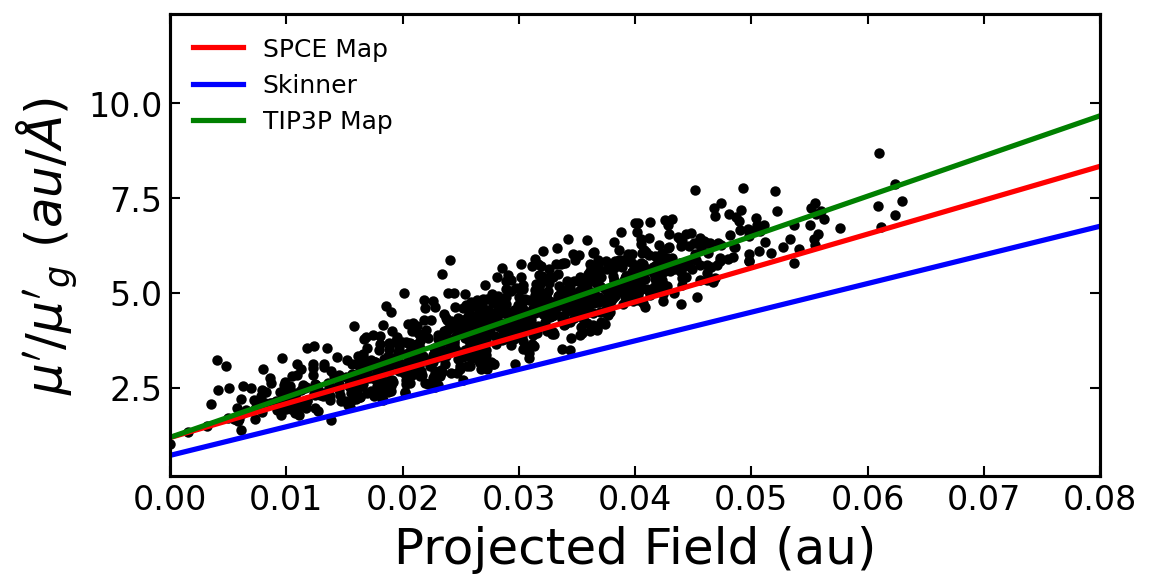

In [81]:
popt, pcov, r2 = tip_map.map_fit_parameters['dmu_num_scaled']
poly = mu_fit_selector(1)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)

skinner = poly(evals, 0.71116, 75.591)

spce = poly(evals, 1.1815, 89.49)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(tip_map.Eproj, tip_map.dmu_num/tip_map.dmu_num[-1], c='black')
plt.plot(evals, spce, c='red', label='SPCE Map')
plt.plot(evals, skinner, c='blue', label='Skinner')
plt.plot(evals, yvalues, c='green', label='TIP3P Map')
plt.legend(frameon=False)
plt.xlabel("Projected Field (au)")
plt.ylabel("$\mu'/\mu'_g~(au/\AA)$")
plt.xlim(0, 0.08)
plt.show()

[ 1.02099378e-01 -9.15189259e-06]


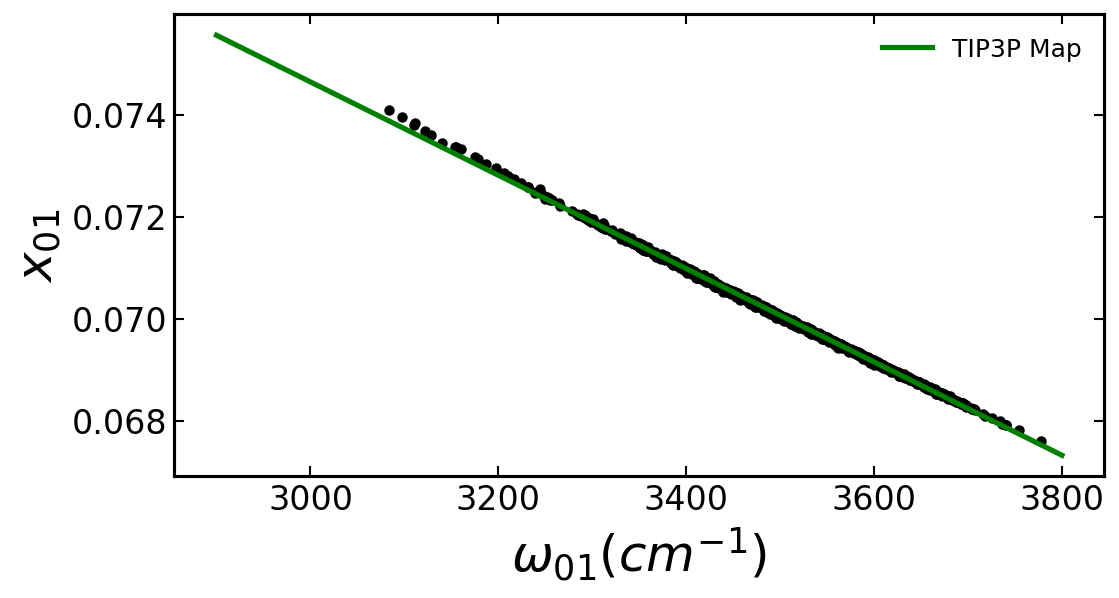

In [85]:
popt, pcov, r2 = tip_map.map_fit_parameters['x01']
poly = mu_fit_selector(1)

evals = np.linspace(2900, 3800, 1000)
yvalues = poly(evals, *popt)
skinner = poly(evals, 0.1024, -0.927E-5)
spce = poly(evals, 0.1025, -0.927E-5)
print(popt)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(tip_map.w01*scale_factor, np.array(tip_map.x01)*constants.angperau, c='black')
#plt.plot(evals, spce, c='red', label='SPCE Map')
#plt.plot(evals, skinner, c='blue', label='Skinner')
plt.plot(evals, yvalues, c='green', label='TIP3P Map')
plt.legend(frameon=False)
plt.xlabel("$\omega_{01} (cm^{-1})$")
plt.ylabel("$x_{01}$")
plt.show()

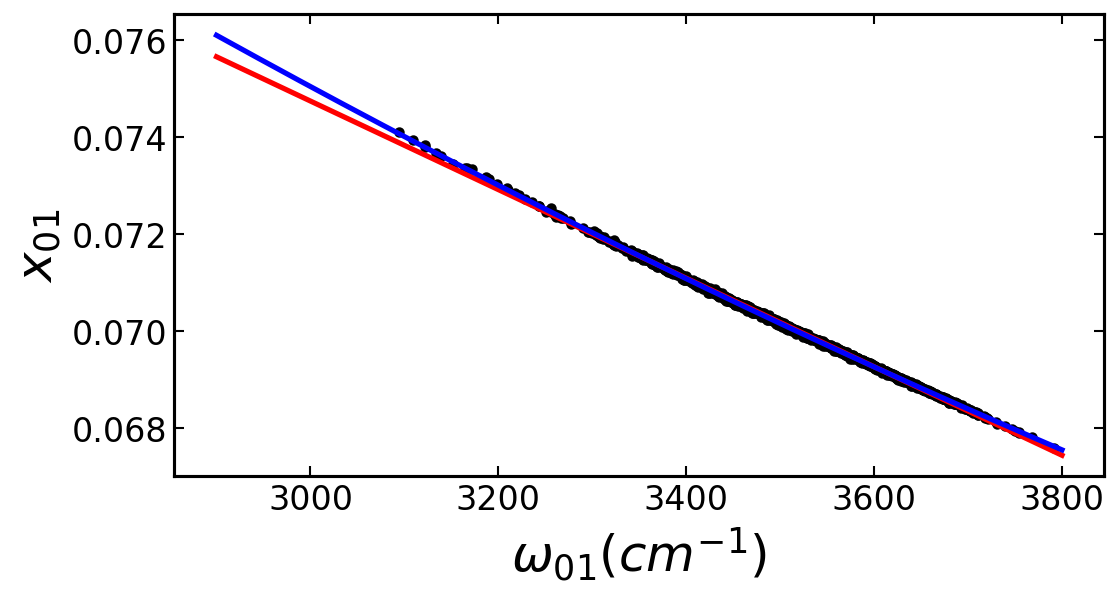

In [83]:
def linear(x, a, b):
    return a*x + b

def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear, tip_map.w01, np.array(tip_map.x01)*constants.angperau)
popt2, pcov2 = curve_fit(quadratic, tip_map.w01, np.array(tip_map.x01)*constants.angperau)

newy = linear(evals, *popt)
newy2 = quadratic(evals, *popt2)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(tip_map.w01, np.array(tip_map.x01)*constants.angperau, c='black')
plt.plot(evals, newy, c='red')
plt.plot(evals, newy2, c='blue')
plt.xlabel("$\omega_{01} (cm^{-1})$")
plt.ylabel("$x_{01}$")
plt.show()


In [ ]:
tip_map.